Step 1: Import Required Libraries

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

Step 2: Load and Merge the Data

In [28]:
# Load data
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
products = pd.read_csv("Products.csv")

# Merge transactions with products
transactions = transactions.merge(products, on="ProductID", how="left")

# Merge transactions with customers
data = transactions.merge(customers, on="CustomerID", how="left")

# Display first few rows
print(data.head())

  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x                      ProductName     Category  Price_y  \
0      300.68   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
1      300.68   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
2      300.68   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
3      601.36   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
4      902.04   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   

      CustomerName         Region  SignupDate  
0   Andrea Jenkins         Europe  202

Step 3: Feature Engineering

In [29]:
# Aggregate transaction data for each customer
customer_features = data.groupby("CustomerID").agg({
    "TotalValue": "sum",                # Total spend
    "TransactionID": "count",           # Number of transactions
    "Quantity": "sum",                  # Total quantity purchased
}).reset_index()

# Add profile information
customer_features = customer_features.merge(customers, on="CustomerID", how="left")

# Encode categorical variables (e.g., Region)
customer_features = pd.get_dummies(customer_features, columns=["Region"], drop_first=True)

# Display the final features
print(customer_features.head())

  CustomerID  TotalValue  TransactionID  Quantity        CustomerName  \
0      C0001     3354.52              5        12    Lawrence Carroll   
1      C0002     1862.74              4        10      Elizabeth Lutz   
2      C0003     2725.38              4        14      Michael Rivera   
3      C0004     5354.88              8        23  Kathleen Rodriguez   
4      C0005     2034.24              3         7         Laura Weber   

   SignupDate  Region_Europe  Region_North America  Region_South America  
0  2022-07-10          False                 False                  True  
1  2022-02-13          False                 False                 False  
2  2024-03-07          False                 False                  True  
3  2022-10-09          False                 False                  True  
4  2022-08-15          False                 False                 False  


Step 4: Preprocessing

In [30]:
# Drop non-numeric columns
features = customer_features.drop(columns=["CustomerID", "CustomerName", "SignupDate"])

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert back to DataFrame for clarity
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)

Step 5: Perform Clustering

In [31]:
# Initialize variables to store clustering metrics
db_index_scores = []
range_n_clusters = range(2, 11)

# Iterate over the range of cluster numbers
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # Compute Davies-Bouldin Index
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    db_index_scores.append(db_index)

# Find the optimal number of clusters with the lowest DB Index
optimal_clusters = range_n_clusters[np.argmin(db_index_scores)]
print(f"Optimal number of clusters: {optimal_clusters}")

Optimal number of clusters: 10


Step 6: Visualize the DB Index

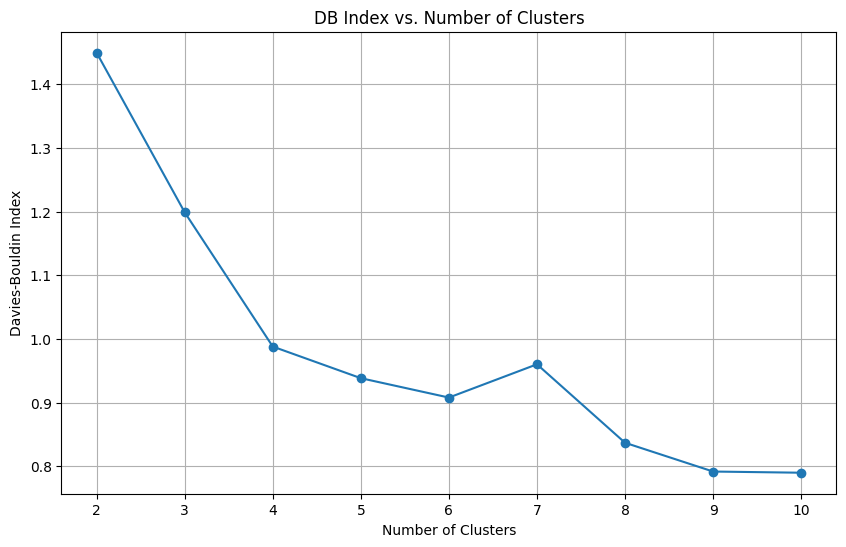

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, db_index_scores, marker="o", linestyle="-")
plt.title("DB Index vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.xticks(range_n_clusters)
plt.grid()
plt.show()

Step 7: Final Clustering and Visualization

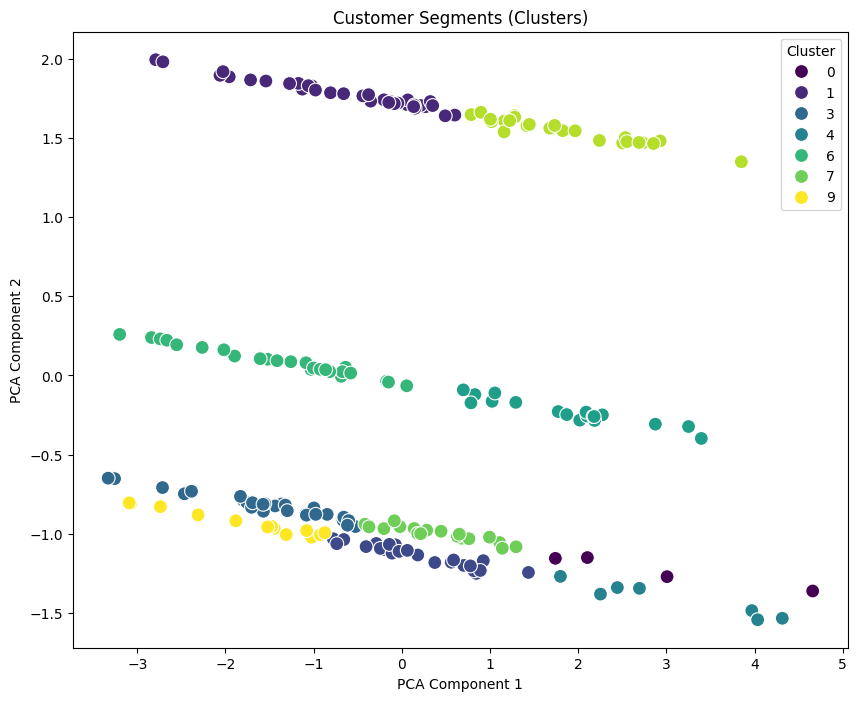

In [33]:
# Final clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features["Cluster"] = kmeans.fit_predict(scaled_features)

# Visualize clusters (use PCA for dimensionality reduction if necessary)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Create a DataFrame for plotting
plot_data = pd.DataFrame(pca_features, columns=["PCA1", "PCA2"])
plot_data["Cluster"] = customer_features["Cluster"]

# Plot clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=plot_data, palette="viridis", s=100)
plt.title("Customer Segments (Clusters)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

Step 8: Report Results

In [34]:
# Calculate Davies-Bouldin Index for the final clustering
final_db_index = davies_bouldin_score(scaled_features, customer_features["Cluster"])
print(f"Davies-Bouldin Index for {optimal_clusters} clusters: {final_db_index}")

# Analyze clusters (numeric columns only)
numeric_columns = customer_features.select_dtypes(include=[np.number]).columns
cluster_analysis = customer_features.groupby("Cluster")[numeric_columns].mean()

# Display cluster analysis
print("Cluster Analysis (Mean Values):")
print(cluster_analysis)

Davies-Bouldin Index for 10 clusters: 0.79002838575684
Cluster Analysis (Mean Values):
          TotalValue  TransactionID   Quantity  Cluster
Cluster                                                
0        6856.610000       8.500000  24.750000      0.0
1        2561.333143       3.971429   9.371429      1.0
2        3334.220385       5.615385  12.961538      2.0
3        2056.031481       3.481481   7.814815      3.0
4        6244.077143       9.285714  24.142857      4.0
5        5379.353889       7.500000  19.611111      5.0
6        2124.869231       3.192308   7.961538      6.0
7        4385.017895       5.578947  15.000000      7.0
8        5404.412500       6.875000  19.208333      8.0
9        1685.779231       2.538462   6.692308      9.0


In [35]:
!pip install fpdf matplotlib

PDF report saved as: Clustering_Report.pdf


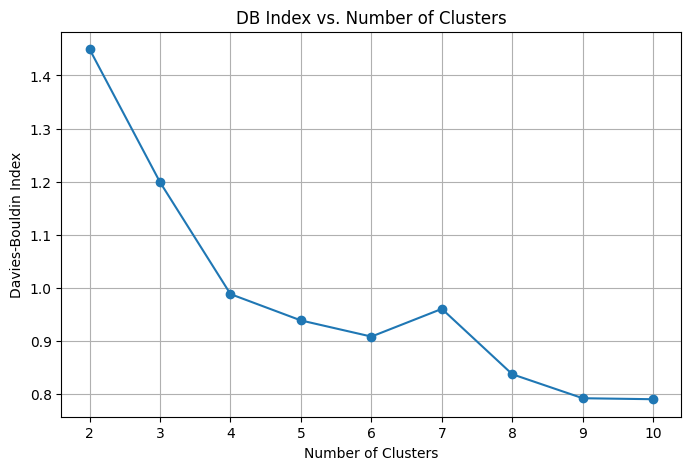

In [36]:
from fpdf import FPDF
import matplotlib.pyplot as plt

# Initialize PDF
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)

# Function to add title and content to the PDF
def add_section_to_pdf(pdf, title, content):
    pdf.set_font("Arial", size=12)
    pdf.add_page()
    pdf.set_font("Arial", style="B", size=16)
    pdf.cell(0, 10, title, ln=True, align="C")
    pdf.ln(10)  # Add space
    pdf.set_font("Arial", size=12)
    for line in content.split("\n"):
        pdf.multi_cell(0, 10, line)

# Add clustering metrics and results to the PDF
clustering_metrics = f"""
Clustering Results
--------------------
Optimal Number of Clusters: {optimal_clusters}
Davies-Bouldin Index: {final_db_index:.4f}

Cluster Analysis (Mean Values):
{cluster_analysis.to_string()}
"""

add_section_to_pdf(pdf, "Clustering Analysis Report", clustering_metrics)

# Add DB Index Plot to PDF
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, db_index_scores, marker="o", linestyle="-")
plt.title("DB Index vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.xticks(range_n_clusters)
plt.grid()

# Save plot as an image and insert into the PDF
plot_path = "db_index_plot.png"
plt.savefig(plot_path)
pdf.add_page()
pdf.set_font("Arial", style="B", size=16)
pdf.cell(0, 10, "DB Index vs. Number of Clusters", ln=True, align="C")
pdf.ln(10)
pdf.image(plot_path, x=10, y=30, w=190)

# Save the PDF
output_pdf_path = "Clustering_Report.pdf"
pdf.output(output_pdf_path)

print(f"PDF report saved as: {output_pdf_path}")